In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries Import and Data Exploration

In [ ]:
%%capture
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
!pip install paddleocr
!pip install paddlepaddle -f https://www.paddlepaddle.org.cn/whl/quick_install.html
from paddleocr import PaddleOCR, draw_ocr
import re
import pandas as pd
from datetime import datetime

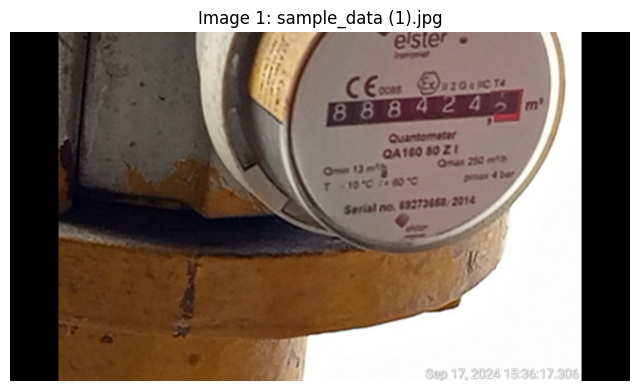

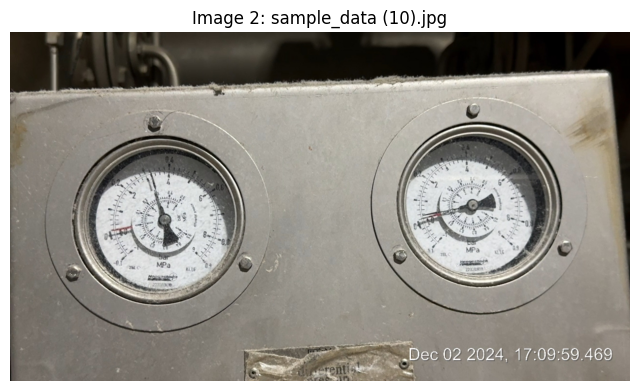

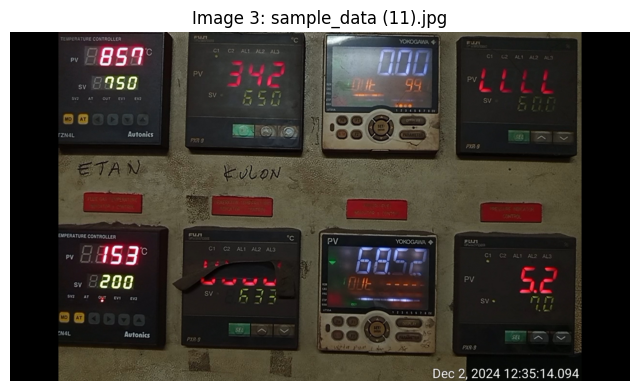

In [ ]:
# load file and show image
folder_path = '/content/drive/MyDrive/sample_data'
image_files = sorted(os.listdir(folder_path))

# show 3 images
for i, img_file in enumerate(image_files[:3]):
    img_path = os.path.join(folder_path, img_file)
    img = cv2.imread(img_path)

    plt.figure(figsize=(8, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i+1}: {img_file}")
    plt.axis('off')
    plt.show()

I found that there're 5 types of dashboard, in each type, has the same dashboard but different information:

First: (1) (7)

Second: (2) (3) (8)

Third: (4) (6) (15)

Forth: (5) (9) (11) (12) (13) (14)

Fifth: (10)

So I decide to build a code template for each type. The basic idea is to proceed code on the first image of each type, then try out if the code is reusable on other images in this type.

In this 'Data Extracting Assessment-1', I'll focus on First Type (1), (7)

# First Type: (1) (7)

It's a flow meter, so I think the important values for this dashboard are current total flow ( with one demical place) and timestamp.

So I will build code template based on sample_data (1), then reuse it on sample_data (7). If the template cannot work on sample_data (7), I'll modify the code.

## sample_data (1)

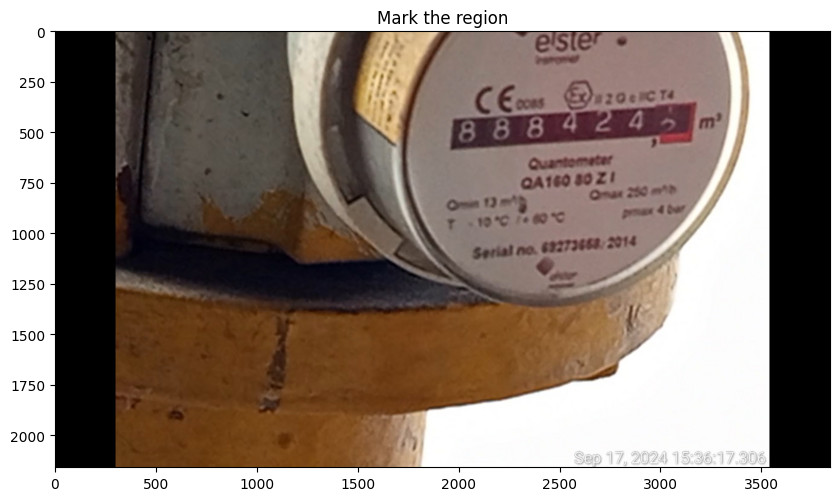

In [86]:
# Show image with oordinate axis
img1 = cv2.imread('/content/drive/MyDrive/sample_data/sample_data (1).jpg')
img_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))
plt.imshow(img_rgb)
plt.title('Mark the region')
plt.show()

For sample data 1 extraction, it follows three main steps:
1. extract current total flow

2. extract timestamp

3. output the csv and annoted image

### Step1: Current Total Flow

#### Extract and Rotate
Because it's hard for tesseract or PaddleOCR to recognize image which is skewed, so need to rotate the image to horizonal line.

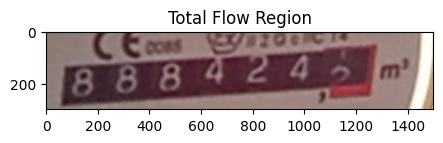

In [87]:
# Roughly extract from original image
totalflow_region = img1[300:600, 1900:3400]

totalflow_rgb = cv2.cvtColor(totalflow_region, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 4))
plt.imshow(totalflow_rgb)
plt.title('Total Flow Region')
plt.show()

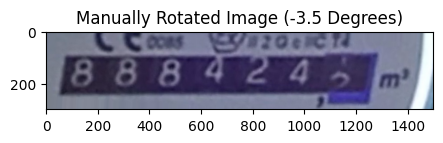

In [88]:
# Rotate the image
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated

rotated_img = rotate_image(totalflow_region, -3.5)

plt.figure(figsize=(5, 4))
plt.imshow(rotated_img, cmap='gray')
plt.title('Manually Rotated Image (-3.5 Degrees)')
plt.show()

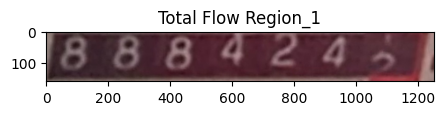

In [89]:
# Extract again after rotated, make sure only current total flow inside the image
totalflow_region_1 = rotated_img[90:250, 50:1300]

totalflow_rgb_1 = cv2.cvtColor(totalflow_region_1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 4))
plt.imshow(totalflow_rgb_1)
plt.title('Total Flow Region_1')
plt.show()

#### Process the extracted image to augment the numbers
Included: transform to gray-scale, denoising using Gaussian Blur, sharpening, binary and inverted, zoom the image

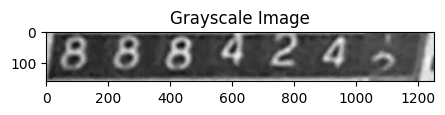

In [90]:
# transform to grey-scale
gray = cv2.cvtColor(totalflow_region_1, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5, 4))
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.show()

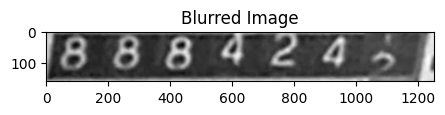

In [91]:
# Denoising using GaussianBlur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(5, 4))
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.show()

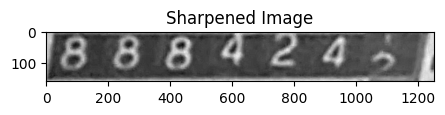

In [92]:
# Sharpening using kernel
import numpy as np

kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened = cv2.filter2D(blurred, -1, kernel)

plt.figure(figsize=(5, 4))
plt.imshow(sharpened, cmap='gray')
plt.title('Sharpened Image')
plt.show()

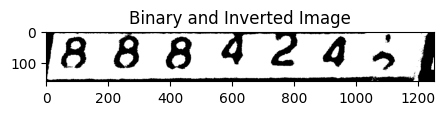

In [93]:
# Binary and inverted the image
_, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
inverted = cv2.bitwise_not(binary)

plt.figure(figsize=(5, 4))
plt.imshow(inverted, cmap='gray')
plt.title('Binary and Inverted Image')
plt.show()

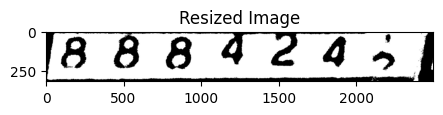

In [94]:
# zoom the image
resized = cv2.resize(inverted, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(5, 4))
plt.imshow(resized, cmap='gray')
plt.title('Resized Image')
plt.show()

#### Recognize Numbers

##### Tesseract alone doesn't work
First I tried to use tesseract to extract numbers from the whole image, but found out that it doesn't work, also cannot handle error of unreadable numbers.

In [95]:
# option 1, use tesseract on resized image:
config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789.'
text = pytesseract.image_to_string(resized, config=config)
print("Extracted Text:", text)

Extracted Text: 1884245



In [96]:
# option 2, use tesseract on inverted image:
config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789.'
text = pytesseract.image_to_string(inverted, config=config)
print("Extracted Text:", text)

Extracted Text: 884245



In [97]:
# option 3, use tesseract on sharpened image:
config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789.'
text = pytesseract.image_to_string(sharpened, config=config)
print("Extracted Text:", text)

Extracted Text: 8842451



##### Tesseract and PaddleOCR with text segment works better
Then I segmented the image into 7 parts (because there're 7 numbers in the dashboard with similar size), and read the number part by part, return the unreadable position with 'N' to handle error.

I tried both PaddleOCR and tesseract, and found out PaddleOCR workes better, but tesseract can recoginze some numbers that PaddleOCR cannot.

So in the final method, I set PaddleOCR as the first layer, and tesseract as second layer. If there are positions return 'N' by first layer, but second layer recognize numbers successfully, the final results will combine the results of two layers.

Result: 88842NN


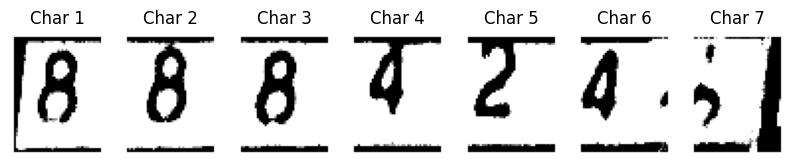

In [98]:
# First layer: PaddleOCR+ inverted

# initialize OCR model
ocr = PaddleOCR(use_angle_cls=False, lang='en')


# cut the image into 7 parts
h, w = inverted.shape
char_width = w // 7

char_images = []
for i in range(7):
    x_start = i * char_width
    x_end = (i + 1) * char_width if i < 6 else w
    char = inverted[:, x_start:x_end]

    pad = 8
    char_padded = cv2.copyMakeBorder(char, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=255)

    char_resized = cv2.resize(char_padded, (48, 64))

    char_bgr = cv2.cvtColor(char_resized, cv2.COLOR_GRAY2BGR)
    char_images.append(char_bgr)

# read the numbers separately, and return 'N' if unreadable
result_text = ""
for idx, img in enumerate(char_images):
    result = ocr.ocr(img, cls=False)
    if result and result[0]:
        text = result[0][0][1][0]
        result_text += text
    else:
        result_text += 'N'

print("Result:", result_text)

plt.figure(figsize=(10, 3))
for i, img in enumerate(char_images):
    plt.subplot(1, 7, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Char {i+1}')
plt.show()


Result: ['N', 'N', 'N', 'N', 'N', '4', '2']


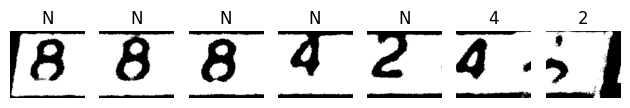

In [99]:
# Second layer: tesseract+ resized

def center_and_resize(char_img, size=(50, 50), pad=10):
    ys, xs = np.where(char_img < 128)
    if len(xs) == 0 or len(ys) == 0:
        return np.ones(size, dtype=np.uint8) * 255

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()

    char_crop = char_img[y1:y2+1, x1:x2+1]

    h, w = char_crop.shape
    scale = min((size[0] - 2 * pad) / h, (size[1] - 2 * pad) / w)
    resized = cv2.resize(char_crop, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR)

    result = np.ones(size, dtype=np.uint8) * 255
    y_offset = (size[0] - resized.shape[0]) // 2
    x_offset = (size[1] - resized.shape[1]) // 2
    result[y_offset:y_offset + resized.shape[0], x_offset:x_offset + resized.shape[1]] = resized

    return result

def recognize_digits(image, digit_count=7):
    height, width = image.shape
    char_width = width // digit_count
    result = []

    for i in range(digit_count):
        x1 = i * char_width
        x2 = (i + 1) * char_width if i < digit_count - 1 else width
        char_img = image[:, x1:x2]

        prepped = center_and_resize(char_img)
        config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789'
        text = pytesseract.image_to_string(prepped, config=config).strip()

        if text.isdigit() and len(text) == 1:
            result.append(text)
        else:
            result.append('N')

    return result

result = recognize_digits(resized)
print("Result:", result)

for i, c in enumerate(result):
    x1 = i * (resized.shape[1] // 7)
    x2 = (i + 1) * (resized.shape[1] // 7)
    plt.subplot(1, 7, i + 1)
    plt.imshow(resized[:, x1:x2], cmap='gray')
    plt.title(c)
    plt.axis('off')
plt.tight_layout()
plt.show()


Combine two layers together:
First: PaddleOCR+inverted

Second: terreract+resized

If there is any unreadable 'N' position from first layer, leave it to second layer to handle

PaddleOCR Result:  ['8', '8', '8', '4', '2', 'N', 'N']
Tesseract Result:  ['N', 'N', 'N', 'N', 'N', '4', '2']
Final Combined Result: 8884242


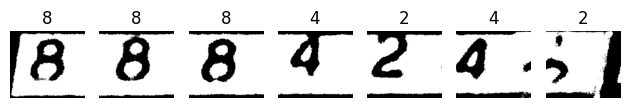

In [100]:
# First layer: PaddleOCR + inverted
# Second layer: terreract + resized


# -------------- First：PaddleOCR（input: inverted image） --------------
def paddle_ocr_digits(inverted):
    ocr = PaddleOCR(use_angle_cls=False, lang='en')
    h, w = inverted.shape
    char_width = w // 7

    results = []
    for i in range(7):
        x_start = i * char_width
        x_end = (i + 1) * char_width if i < 6 else w
        char = inverted[:, x_start:x_end]
        char_padded = cv2.copyMakeBorder(char, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=255)
        char_resized = cv2.resize(char_padded, (48, 64))
        char_bgr = cv2.cvtColor(char_resized, cv2.COLOR_GRAY2BGR)

        result = ocr.ocr(char_bgr, cls=False)
        if result and result[0]:
            text = result[0][0][1][0]
            results.append(text if text.isdigit() and len(text) == 1 else 'N')
        else:
            results.append('N')

    return results

# -------------- Second：Tesseract（input resized image） --------------
def center_and_resize(char_img, size=(50, 50), pad=10):
    ys, xs = np.where(char_img < 128)
    if len(xs) == 0 or len(ys) == 0:
        return np.ones(size, dtype=np.uint8) * 255

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    char_crop = char_img[y1:y2+1, x1:x2+1]

    h, w = char_crop.shape
    scale = min((size[0] - 2 * pad) / h, (size[1] - 2 * pad) / w)
    resized = cv2.resize(char_crop, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR)

    result = np.ones(size, dtype=np.uint8) * 255
    y_offset = (size[0] - resized.shape[0]) // 2
    x_offset = (size[1] - resized.shape[1]) // 2
    result[y_offset:y_offset + resized.shape[0], x_offset:x_offset + resized.shape[1]] = resized

    return result

def tesseract_digits(resized):
    height, width = resized.shape
    char_width = width // 7
    results = []

    for i in range(7):
        x1 = i * char_width
        x2 = (i + 1) * char_width if i < 6 else width
        char_img = resized[:, x1:x2]

        prepped = center_and_resize(char_img)
        config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789'
        text = pytesseract.image_to_string(prepped, config=config).strip()

        if text.isdigit() and len(text) == 1:
            results.append(text)
        else:
            results.append('N')

    return results

# -------------- combine results --------------
def combined_ocr(inverted, resized):
    layer1 = paddle_ocr_digits(inverted)
    layer2 = tesseract_digits(resized)

    combined = [a if a != 'N' else b for a, b in zip(layer1, layer2)]
    return layer1, layer2, combined

# -------------- visualization --------------
layer1_result, layer2_result, final_result = combined_ocr(inverted, resized)
final_result_str = ''.join(final_result)

print("PaddleOCR Result: ", layer1_result)
print("Tesseract Result: ", layer2_result)
print("Final Combined Result:", final_result_str)

for i, c in enumerate(final_result):
    x1 = i * (resized.shape[1] // 7)
    x2 = (i + 1) * (resized.shape[1] // 7)
    plt.subplot(1, 7, i + 1)
    plt.imshow(resized[:, x1:x2], cmap='gray')
    plt.title(c)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Step 2: Timestamp

#### Extract
Because the timestamp is already horizonal, so no need for rotate.

In [101]:
print(img1.shape)

(2160, 3840, 3)


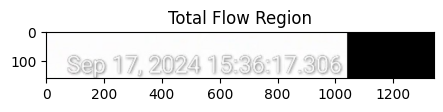

In [102]:
totalflow_region = img1[2000:2160, 2500:3840]

totalflow_rgb = cv2.cvtColor(totalflow_region, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 4))
plt.imshow(totalflow_rgb)
plt.title('Total Flow Region')
plt.show()

#### Process the extracted image to augment the text
Because the timestamp has similar color as the background, so need to focus on augmenting the text.

Included: transform to gray-scale, ehnace, sharpening, binary and inverted.

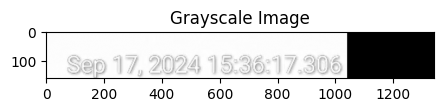

In [103]:
# transform to grey-scale
gray = cv2.cvtColor(totalflow_region, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5, 4))
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.show()

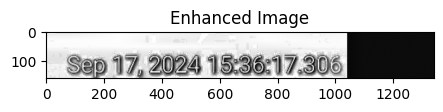

In [104]:
# Enhance the image
clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

plt.figure(figsize=(5, 4))
plt.imshow(enhanced, cmap='gray')
plt.title('Enhanced Image')
plt.show()

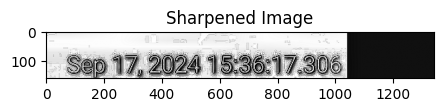

In [105]:
# Sharpening using kernel

kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened = cv2.filter2D(enhanced, -1, kernel)

plt.figure(figsize=(5, 4))
plt.imshow(sharpened, cmap='gray')
plt.title('Sharpened Image')
plt.show()

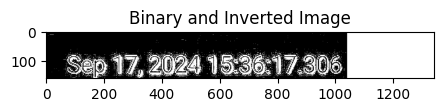

In [106]:
# Binary and inverted the image
_, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
inverted = cv2.bitwise_not(binary)

plt.figure(figsize=(5, 4))
plt.imshow(inverted, cmap='gray')
plt.title('Binary and Inverted Image')
plt.show()

#### Recognize the text

I tried terreract first and it didn't work.

So for the second method, I used PaddleOCR, and it worked quite well on the timestamp exteaction task. Maybe because the time stamp is clear and easier to distinguish from the background.

In [107]:
# option 1: tesseract, it's not working
if len(inverted.shape) == 2:
    ocr_input = inverted
else:
    ocr_input = cv2.cvtColor(inverted, cv2.COLOR_BGR2RGB)

raw_text = pytesseract.image_to_string(ocr_input)

print('raw_text', raw_text)

raw_text  



In [108]:
# option 2: change to more advance method: PaddleOCR + regularization

ocr = PaddleOCR(use_angle_cls=True, lang='en')

if len(inverted.shape) == 2:
    inverted_bgr = cv2.cvtColor(inverted, cv2.COLOR_GRAY2BGR)
else:
    inverted_bgr = inverted

result = ocr.ocr(inverted_bgr, cls=True)

for line in result[0]:
    text = line[1][0]
    confidence = line[1][1]

    formatted_text = re.sub(r'(\b[Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec]{3})\s*(\d{1,2})\.(\d{4})\s*(\d{2}):(\d{2}):(\d{2}\.\d{3})', r'\1 \2.\3 \4:\5:\6', text)

    print(f"text: {formatted_text}, confidence: {confidence:.2f}")

text: Sep 17.2024 15:36:17.306, confidence: 0.95


### Step 3: Output the data

In [109]:
# add decimal point to current total flow
final_result_with_dot = final_result_str[:-1] + '.' + final_result_str[-1]
print(final_result_with_dot)

888424.2


#### Output in csv file

In [110]:
output_path = '/content/drive/MyDrive/data_extracting_assessment_outputs/output_sample_1.csv'

df = pd.DataFrame({
    'current_total_flow': [final_result_with_dot],
    'timestamp': [formatted_text]
})

os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, mode='w', index=False, header=not os.path.exists(output_path))


#### Output in annoted image

I copied the original image and annoted the current total flow and timestamp next to the text on image.

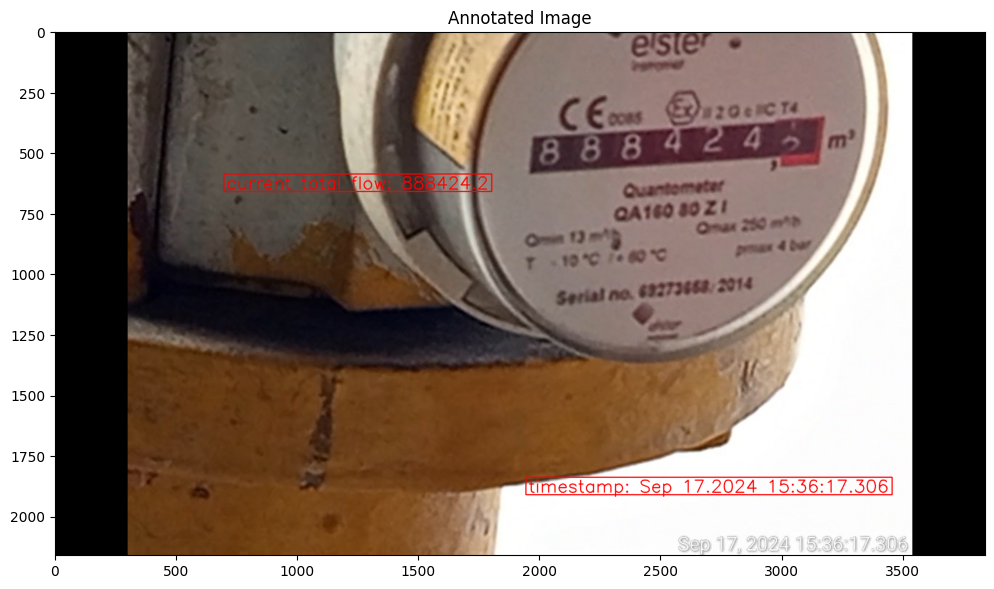

In [111]:
# read original image and make a copy
img1 = cv2.imread('/content/drive/MyDrive/sample_data/sample_data (1).jpg')
copy_img1 = img1.copy()

# prepare annotation texts
flow_text = f"current total flow: {final_result_with_dot}"
timestamp_text = f"timestamp: {formatted_text}"

# set font style and color: red
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2.4
font_thickness = 4
font_color = (0, 0, 255)  # red
rectangle_color = (0, 0, 255)  # red

# helper function to draw text with bounding box
def draw_text_with_box(img, text, x_range, y_range):
    x_center = (x_range[0] + x_range[1]) // 2
    y_center = (y_range[0] + y_range[1]) // 2

    # calculate text size
    (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)

    # compute top-left corner of text to center it inside the region
    top_left_x = x_center - text_width // 2
    top_left_y = y_center - text_height // 2

    # draw rectangle box slightly larger than text
    cv2.rectangle(img,
                  (top_left_x - 10, top_left_y - 10),
                  (top_left_x + text_width + 10, top_left_y + text_height + 10),
                  rectangle_color, 4)

    # put text inside the rectangle
    cv2.putText(img, text,
                (top_left_x, top_left_y + text_height),
                font, font_scale, font_color, font_thickness)

# ----- annotate current_total_flow -----
# region: x 1000-1500,  y 500-750
draw_text_with_box(copy_img1, flow_text, x_range=(1000, 1500), y_range=(500, 750))

# ----- annotate timestamp -----
# region: x 2200-3200, y 1750-2000,
draw_text_with_box(copy_img1, timestamp_text, x_range=(2200, 3200), y_range=(1750, 2000))

# ----- save and visualize output -----
output_path = '/content/drive/MyDrive/data_extracting_assessment_outputs/output_sample_1.jpg'
cv2.imwrite(output_path, copy_img1)

# visualize in notebook
img_rgb = cv2.cvtColor(copy_img1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 10))
plt.imshow(img_rgb)
plt.title("Annotated Image")
plt.axis('on')
plt.show()


## sample_data (7)

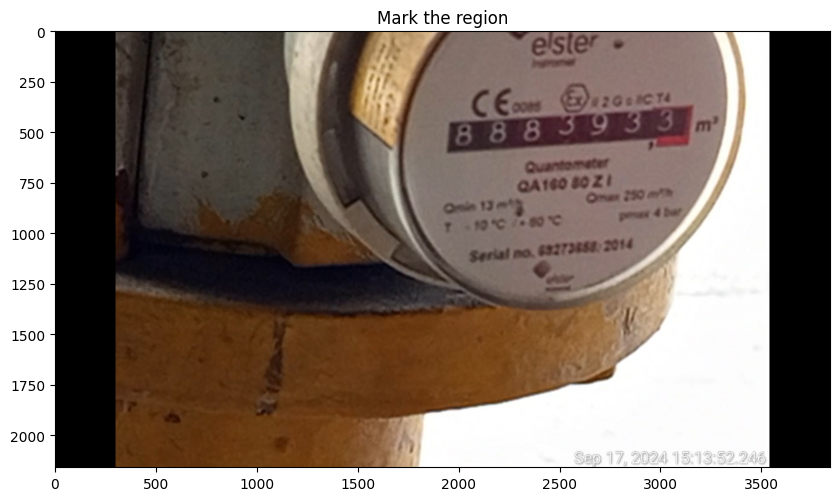

In [112]:
# Show image with oordinate axis
img7 = cv2.imread('/content/drive/MyDrive/sample_data/sample_data (7).jpg')
img_rgb = cv2.cvtColor(img7, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))
plt.imshow(img_rgb)
plt.title('Mark the region')
plt.show()

For sample data 7, it follows three main steps:

extract current total flow

extract timestamp

output the csv and annoted image

### Step 1: Current Total Flow

#### Extract and Rotate

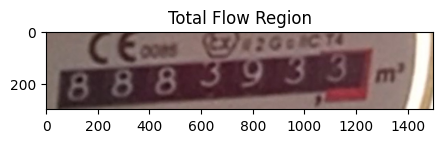

In [113]:
# Roughly extract from original image
totalflow_region = img7[300:600, 1900:3400]

totalflow_rgb = cv2.cvtColor(totalflow_region, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 4))
plt.imshow(totalflow_rgb)
plt.title('Total Flow Region')
plt.show()

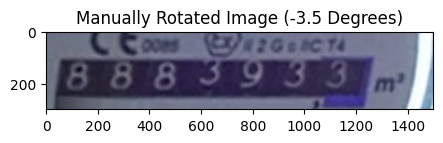

In [114]:
# Rotate the image
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated

rotated_img = rotate_image(totalflow_region, -3.7)

plt.figure(figsize=(5, 4))
plt.imshow(rotated_img, cmap='gray')
plt.title('Manually Rotated Image (-3.5 Degrees)')
plt.show()

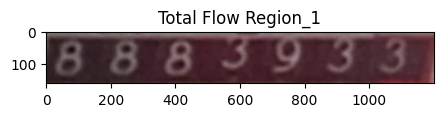

In [115]:
# Extract again after rotated, make sure only current total flow inside the image
totalflow_region_1 = rotated_img[90:250, 50:1250]

totalflow_rgb_1 = cv2.cvtColor(totalflow_region_1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 4))
plt.imshow(totalflow_rgb_1)
plt.title('Total Flow Region_1')
plt.show()

#### Process the extracted image
Included: transform to gray-scale, denoising using Gaussian Blur, sharpening, binary and inverted, zoom the image

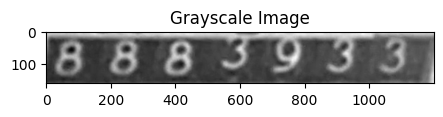

In [116]:
# transform to grey-scale
gray = cv2.cvtColor(totalflow_region_1, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5, 4))
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.show()

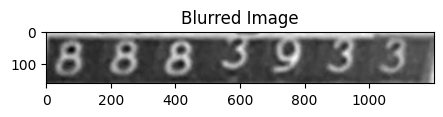

In [117]:
# Denoising using GaussianBlur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(5, 4))
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.show()

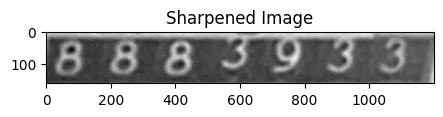

In [118]:
# Sharpening using kernel
import numpy as np

kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened = cv2.filter2D(blurred, -1, kernel)

plt.figure(figsize=(5, 4))
plt.imshow(sharpened, cmap='gray')
plt.title('Sharpened Image')
plt.show()

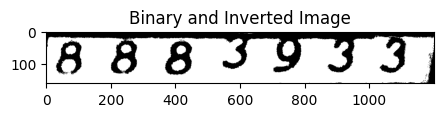

In [119]:
# Binary and inverted the image
_, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
inverted = cv2.bitwise_not(binary)

plt.figure(figsize=(5, 4))
plt.imshow(inverted, cmap='gray')
plt.title('Binary and Inverted Image')
plt.show()

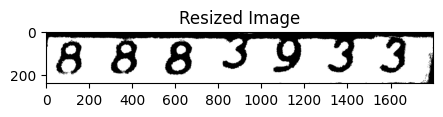

In [120]:
# zoom the image
resized = cv2.resize(inverted, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(5, 4))
plt.imshow(resized, cmap='gray')
plt.title('Resized Image')
plt.show()

#### Recognize Numbers

With the prior experience in sample_data(1), for this image I'll start from using segment image with two layers (first: Paddle+ inverted image, second: tesseract+resized image) to read image.

##### Two layers method works but not perfect
With the prior experience in sample_data(1), for this image I'll start from using segment image with two layers (first: Paddle+ inverted image, second: tesseract+resized image) to read image.

PaddleOCR Result:  ['N', '8', '8', '3', '9', 'N', '3']
Tesseract Result:  ['N', 'N', 'N', 'N', 'N', 'N', '3']
Final Combined Result: N8839N3


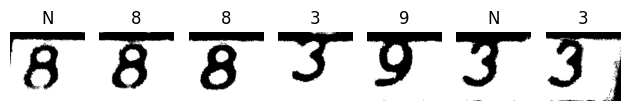

In [121]:
# ---------- First layer: PaddleOCR + inverted image----------
def paddle_ocr_digits(inverted, digit_count=7):
    ocr = PaddleOCR(use_angle_cls=True, lang='en')
    if len(inverted.shape) == 3:
        inverted = cv2.cvtColor(inverted, cv2.COLOR_BGR2GRAY)

    h, w = inverted.shape
    char_width = w // digit_count
    results = []

    for i in range(digit_count):
        x_start = i * char_width
        x_end = (i + 1) * char_width if i < digit_count - 1 else w
        char = inverted[:, x_start:x_end]

        char_padded = cv2.copyMakeBorder(char, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=255)
        char_resized = cv2.resize(char_padded, (48, 64))

        char_bgr = cv2.cvtColor(char_resized, cv2.COLOR_GRAY2BGR)
        result = ocr.ocr(char_bgr, cls=False)

        if result and result[0]:
            text = result[0][0][1][0]
            results.append(text if text.isdigit() and len(text) == 1 else 'N')
        else:
            results.append('N')

    return results

# ---------- Second layer: Tesseract + resized image----------
def center_and_resize(char_img, size=(50, 50), pad=10):
    if len(char_img.shape) == 3:
        char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)

    ys, xs = np.where(char_img < 128)
    if len(xs) == 0 or len(ys) == 0:
        return np.ones(size, dtype=np.uint8) * 255

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    char_crop = char_img[y1:y2+1, x1:x2+1]

    h, w = char_crop.shape
    scale = min((size[0] - 2 * pad) / h, (size[1] - 2 * pad) / w)
    resized = cv2.resize(char_crop, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR)

    result = np.ones(size, dtype=np.uint8) * 255
    y_offset = (size[0] - resized.shape[0]) // 2
    x_offset = (size[1] - resized.shape[1]) // 2
    result[y_offset:y_offset + resized.shape[0], x_offset:x_offset + resized.shape[1]] = resized

    return result

def tesseract_digits(resized, digit_count=7):
    if len(resized.shape) == 3:
        resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    height, width = resized.shape
    char_width = width // digit_count
    results = []

    for i in range(digit_count):
        x1 = i * char_width
        x2 = (i + 1) * char_width if i < digit_count - 1 else width
        char_img = resized[:, x1:x2]

        prepped = center_and_resize(char_img)
        config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789'
        text = pytesseract.image_to_string(prepped, config=config).strip()

        if text.isdigit() and len(text) == 1:
            results.append(text)
        else:
            results.append('N')

    return results

# ---------- combine two layers ----------
def combined_ocr(inverted, resized, digit_count=7):
    layer1 = paddle_ocr_digits(inverted, digit_count)
    layer2 = tesseract_digits(resized, digit_count)
    combined = [a if a != 'N' else b for a, b in zip(layer1, layer2)]
    return layer1, layer2, combined



layer1_result, layer2_result, final_result = combined_ocr(inverted, resized)
final_result_str_1 = ''.join(final_result)

print("PaddleOCR Result: ", layer1_result)
print("Tesseract Result: ", layer2_result)
print("Final Combined Result:", final_result_str_1)

# ---------- visualization ----------
for i, c in enumerate(final_result):
    x1 = i * (resized.shape[1] // 7)
    x2 = (i + 1) * (resized.shape[1] // 7)
    plt.subplot(1, 7, i + 1)
    plt.imshow(resized[:, x1:x2], cmap='gray')
    plt.title(c)
    plt.axis('off')
plt.tight_layout()
plt.show()


##### Try onpencv number template match as third layer
Because there are some positions still unreadable, so I tried third layer method.

I used opencv to generate 0-9 numbers template and hope to match the unreadable numbers with the template.

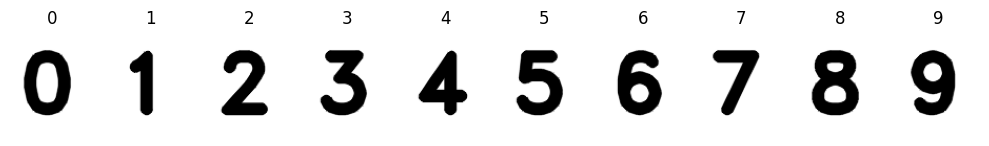

In [122]:
output_dir = "templates"
os.makedirs(output_dir, exist_ok=True)

# set font and scale
font = cv2.FONT_HERSHEY_DUPLEX
font_scale = 2.5
thickness = 7

# generate template
for digit in range(10):
    img = np.ones((100, 80), dtype=np.uint8) * 255
    cv2.putText(img, str(digit), (10, 75), font, font_scale, (0,), thickness, lineType=cv2.LINE_AA)

    cv2.imwrite(os.path.join(output_dir, f"{digit}.png"), img)

plt.figure(figsize=(10, 2))
for i in range(10):
    img_path = os.path.join(output_dir, f"{i}.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(str(i))
    plt.axis('off')
plt.tight_layout()
plt.show()


PaddleOCR Result:  ['N', '8', '8', '3', '9', 'N', '3']
Tesseract Result:  ['N', 'N', 'N', 'N', 'N', 'N', '3']
Template Matching Result:  ['4', '4', '7', '4', '4', '4', '6']
Final Combined Result: 4883943


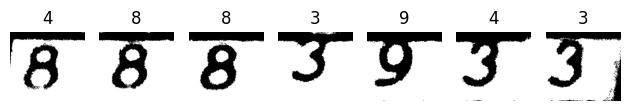

In [123]:
# Three layers method

# ---------- First layer: PaddleOCR + inverted image ----------
def paddle_ocr_digits(inverted, digit_count=7):
    ocr = PaddleOCR(use_angle_cls=True, lang='en')
    if len(inverted.shape) == 3:
        inverted = cv2.cvtColor(inverted, cv2.COLOR_BGR2GRAY)

    h, w = inverted.shape
    char_width = w // digit_count
    results = []

    for i in range(digit_count):
        x_start = i * char_width
        x_end = (i + 1) * char_width if i < digit_count - 1 else w
        char = inverted[:, x_start:x_end]

        char_padded = cv2.copyMakeBorder(char, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=255)
        char_resized = cv2.resize(char_padded, (48, 64))

        char_bgr = cv2.cvtColor(char_resized, cv2.COLOR_GRAY2BGR)
        result = ocr.ocr(char_bgr, cls=False)

        if result and result[0]:
            text = result[0][0][1][0]
            results.append(text if text.isdigit() and len(text) == 1 else 'N')
        else:
            results.append('N')

    return results


# ---------- Second: Tesseract + resized image----------
def center_and_resize(char_img, size=(50, 50), pad=10):
    if len(char_img.shape) == 3:
        char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)

    ys, xs = np.where(char_img < 128)
    if len(xs) == 0 or len(ys) == 0:
        return np.ones(size, dtype=np.uint8) * 255

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    char_crop = char_img[y1:y2+1, x1:x2+1]

    h, w = char_crop.shape
    scale = min((size[0] - 2 * pad) / h, (size[1] - 2 * pad) / w)
    resized = cv2.resize(char_crop, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR)

    result = np.ones(size, dtype=np.uint8) * 255
    y_offset = (size[0] - resized.shape[0]) // 2
    x_offset = (size[1] - resized.shape[1]) // 2
    result[y_offset:y_offset + resized.shape[0], x_offset:x_offset + resized.shape[1]] = resized

    return result

def tesseract_digits(resized, digit_count=7):
    if len(resized.shape) == 3:
        resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    height, width = resized.shape
    char_width = width // digit_count
    results = []

    for i in range(digit_count):
        x1 = i * char_width
        x2 = (i + 1) * char_width if i < digit_count - 1 else width
        char_img = resized[:, x1:x2]

        prepped = center_and_resize(char_img)
        config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789'
        text = pytesseract.image_to_string(prepped, config=config).strip()

        if text.isdigit() and len(text) == 1:
            results.append(text)
        else:
            results.append('N')

    return results


# ---------- Third layer: matching with template ---------
def generate_templates():
    output_dir = "templates"
    os.makedirs(output_dir, exist_ok=True)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.5
    thickness = 7

    for digit in range(10):
        img = np.ones((100, 80), dtype=np.uint8) * 255
        cv2.putText(img, str(digit), (10, 75), font, font_scale, (0,), thickness, lineType=cv2.LINE_AA)
        cv2.imwrite(os.path.join(output_dir, f"{digit}.png"), img)

def template_matching(resized, digit_count=7):
    template_dir = "templates"
    templates = [cv2.imread(os.path.join(template_dir, f"{i}.png"), cv2.IMREAD_GRAYSCALE) for i in range(10)]

    if len(resized.shape) == 3:
        resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    height, width = resized.shape
    char_width = width // digit_count
    results = []

    for i in range(digit_count):
        x1 = i * char_width
        x2 = (i + 1) * char_width if i < digit_count - 1 else width
        char_img = resized[:, x1:x2]

        scores = []
        for template in templates:
            res = cv2.matchTemplate(char_img, template, cv2.TM_CCOEFF_NORMED)
            scores.append(res.max())

        best_match = np.argmax(scores)
        if scores[best_match] > 0.1:  # fine the threshold
            results.append(str(best_match))
        else:
            results.append('N')

    return results


# ---------- combine three layers ----------
def combined_ocr(inverted, resized, digit_count=7):
    layer1 = paddle_ocr_digits(inverted, digit_count)

    layer2 = tesseract_digits(resized, digit_count)

    layer3 = template_matching(resized, digit_count)

    combined = [a if a != 'N' else (b if b != 'N' else c) for a, b, c in zip(layer1, layer2, layer3)]

    return layer1, layer2, layer3, combined


layer1_result, layer2_result, layer3_result, final_result = combined_ocr(inverted, resized)
final_result_str_2 = ''.join(final_result)

print("PaddleOCR Result: ", layer1_result)
print("Tesseract Result: ", layer2_result)
print("Template Matching Result: ", layer3_result)
print("Final Combined Result:", final_result_str_2)

# ---------- visualization ----------
for i, c in enumerate(final_result):
    x1 = i * (resized.shape[1] // 7)
    x2 = (i + 1) * (resized.shape[1] // 7)
    plt.subplot(1, 7, i + 1)
    plt.imshow(resized[:, x1:x2], cmap='gray')
    plt.title(c)
    plt.axis('off')
plt.tight_layout()
plt.show()

By tuning the threshold of matching, I found out that the third layer will match any number with 4, which is incorrect.

So after trading off  between accuracy and quantity, I think accuracy is more important, so I'll keep the two layers result: 'final_result_str_1'.

### Step 2: Timestamp

#### Extract
Because the timestamp is already horizonal, so no need for rotating.

In [124]:
print(img7.shape)

(2160, 3840, 3)


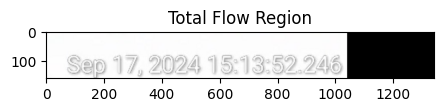

In [125]:
totalflow_region = img7[2000:2160, 2500:3840]

totalflow_rgb = cv2.cvtColor(totalflow_region, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 4))
plt.imshow(totalflow_rgb)
plt.title('Total Flow Region')
plt.show()

#### Process the extracted image to augment the text
Because the timestamp has similar color as the bachground, so need to focus on augmenting the text.

Included: transform to gray-scale, ehnace, sharpening, binary and inverted.

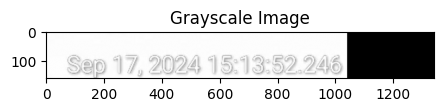

In [126]:
# transform to grey-scale
gray = cv2.cvtColor(totalflow_region, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5, 4))
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.show()

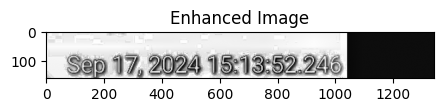

In [127]:
# Enhance the image
clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

plt.figure(figsize=(5, 4))
plt.imshow(enhanced, cmap='gray')
plt.title('Enhanced Image')
plt.show()

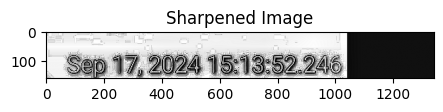

In [128]:
# Sharpening using kernel

kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened = cv2.filter2D(enhanced, -1, kernel)

plt.figure(figsize=(5, 4))
plt.imshow(sharpened, cmap='gray')
plt.title('Sharpened Image')
plt.show()

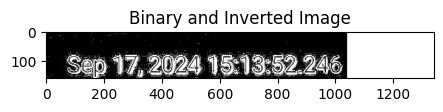

In [129]:
# Binary and inverted the image
_, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
inverted = cv2.bitwise_not(binary)

plt.figure(figsize=(5, 4))
plt.imshow(inverted, cmap='gray')
plt.title('Binary and Inverted Image')
plt.show()

#### Recognize the text

With prior experience, for sample data (7) timestamp extracting, I'll try the advance method PaddleOCR directly.

In [130]:
# try advance method directly: PaddleOCR + regularization
ocr = PaddleOCR(use_angle_cls=True, lang='en')

if len(inverted.shape) == 2:
    inverted_bgr = cv2.cvtColor(inverted, cv2.COLOR_GRAY2BGR)
else:
    inverted_bgr = inverted

result = ocr.ocr(inverted_bgr, cls=True)

for line in result[0]:
    text = line[1][0]
    confidence = line[1][1]

    formatted_text = re.sub(r'(\b[Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec]{3})\s*(\d{1,2})\.(\d{4})\s*(\d{2}):(\d{2}):(\d{2}\.\d{3})', r'\1 \2.\3 \4:\5:\6', text)

    print(f"text: {formatted_text}, confidence: {confidence:.2f}")

text: Sep 17.2024 15:13:52.246, confidence: 0.92


### Step 3: Output the data

In [131]:
# add decimal point to current total flow
final_result_with_dot = final_result_str_1[:-1] + '.' + final_result_str_1[-1]
print(final_result_with_dot)

N8839N.3


#### Output in csv file

In [132]:
output_path = '/content/drive/MyDrive/data_extracting_assessment_outputs/output_sample_7.csv'

df = pd.DataFrame({
    'current_total_flow': [final_result_with_dot],
    'timestamp': [formatted_text]
})

os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, mode='w', index=False, header=not os.path.exists(output_path))


#### Output in annoted image

I copied the original image and annoted the current total flow and timestamp next to the text on image.

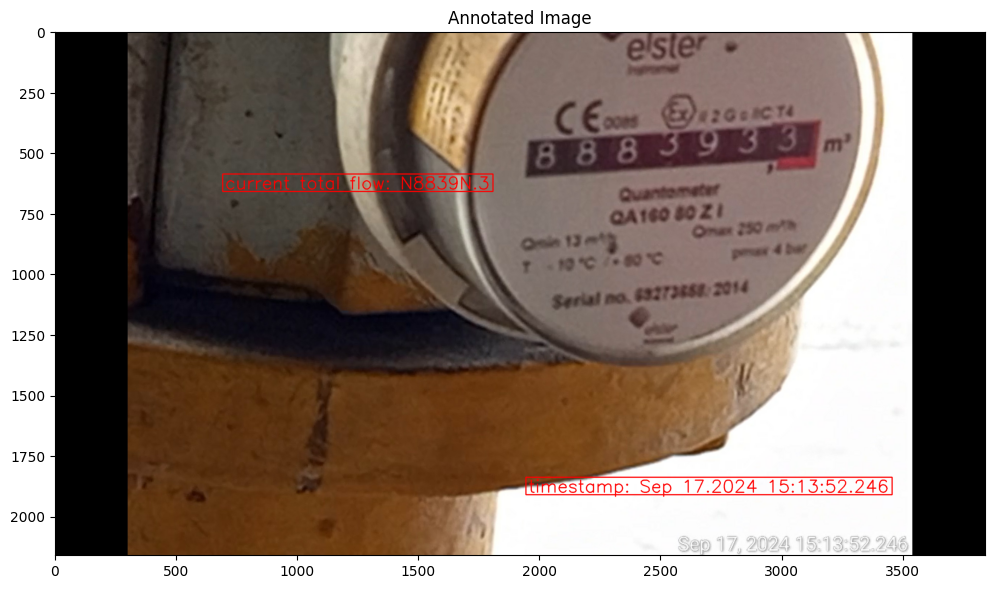

In [133]:
# read original image and make a copy
img1 = cv2.imread('/content/drive/MyDrive/sample_data/sample_data (7).jpg')
copy_img1 = img1.copy()

# prepare annotation texts
flow_text = f"current total flow: {final_result_with_dot}"
timestamp_text = f"timestamp: {formatted_text}"

# set font style and color: red
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2.4
font_thickness = 4
font_color = (0, 0, 255)  # red
rectangle_color = (0, 0, 255)  # red

# helper function to draw text with bounding box
def draw_text_with_box(img, text, x_range, y_range):
    x_center = (x_range[0] + x_range[1]) // 2
    y_center = (y_range[0] + y_range[1]) // 2

    # calculate text size
    (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)

    # compute top-left corner of text to center it inside the region
    top_left_x = x_center - text_width // 2
    top_left_y = y_center - text_height // 2

    # draw rectangle box slightly larger than text
    cv2.rectangle(img,
                  (top_left_x - 10, top_left_y - 10),
                  (top_left_x + text_width + 10, top_left_y + text_height + 10),
                  rectangle_color, 4)

    # put text inside the rectangle
    cv2.putText(img, text,
                (top_left_x, top_left_y + text_height),
                font, font_scale, font_color, font_thickness)

# ----- annotate current_total_flow -----
# region: x 1000-1500,  y 500-750
draw_text_with_box(copy_img1, flow_text, x_range=(1000, 1500), y_range=(500, 750))

# ----- annotate timestamp -----
# region: x 2200-3200, y 1750-2000,
draw_text_with_box(copy_img1, timestamp_text, x_range=(2200, 3200), y_range=(1750, 2000))

# ----- save and visualize output -----
output_path = '/content/drive/MyDrive/data_extracting_assessment_outputs/output_sample_7.jpg'
cv2.imwrite(output_path, copy_img1)

# visualize in notebook
img_rgb = cv2.cvtColor(copy_img1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 10))
plt.imshow(img_rgb)
plt.title("Annotated Image")
plt.axis('on')
plt.show()
